# 3'READS+ Pipeline (Part 3)

**Part 3 of the 3'READS+ pipeline will use machine learning to gain some biological insights with the following steps:**
1. Prepare training and test data
2. Select the most promising models using cross validation
3. Fine tune hyper parameters of the support vector machine (SVM) model and the gradient boosting tree (XGboost) model
4. Model interpretation

**Required softwares**
* Python packages: pathlib, np, pandas, altair, sklern, XGboost, shap, etc
* Jupyter Lab or Jupyter Notebook for running this notebook
* Linux environment

In this notebook, I will use transcript features such as size and GC% of 5'UTR, CDS, 3'UTR, RNA folding engergy in 3'UTR, 3'UTR RNA binding protein binding score, and intron features to predict nuclear enrichment measured by log2(Nuclear/Cytoplasm). By examining the best model I can get some insights on how some of the features may contribute to RNA nuclear enrichment.

**Note: This is just an example notebook. In my research, I have used similar notebooks to built models to find genomic and sequence features that are important for RNA stability, poly(A) tail size, translation, and localization to ER/mitochondria.** Hopefully my findings can be published soon. 

## 1. Prepare training and test data sets

## 1.1. Load data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import pandas as pd
import numpy as np
import altair as alt

In [3]:
# Project and experiment directories are automatically figured out
exp_dir = Path('..')
PROJECT, EXPERIMENT = exp_dir.cwd().parts[-3:-1]

# SETTING has to be manually set.
SETTING = 'NC'
result_dir = exp_dir/'results'/SETTING

df = pd.read_csv(result_dir/'pas.csv')

Uncomment the following line to see column names:

In [4]:
# df.columns.values

## 1.2. Prepare data

Select useful columns. I will use size, GC%, RNA structure, and RBP binding score features to predict nuclear cytoplasmic ratio of alternative polyadenylation isoform-specific RNA.

In [4]:
df = (df
      .loc[df['region']=='3UTR']
      .filter(regex='intron|_size$|_GC$|_mfe_|RBP|NT_N_C_FC|gene_symbol|pAid')
      .drop(df.filter(regex='ncRNA|has_intron').columns, axis=1)
      .replace([np.inf, -np.inf], np.nan)
      .dropna(axis=0, how="any")
      )
df = df.set_index(['gene_symbol', 'pAid'])

Uncomment the following line to see null values:

In [6]:
# df.isnull().sum()

Uncomment the following line to see description of the columns:

In [7]:
# Have a quick look at the data frame
# pd.set_option('display.max_rows', 500)
# df.describe().T
# pd.set_option('display.max_rows', 20)

Uncomment the following line to see data types of the columns:

In [8]:
# df.dtypes
# df.info()

Set data types if necessary:

In [5]:
df = pd.concat([df.filter(regex='^num_|_size$').astype('int64'), 
                df.drop(df.filter(regex='^num_|_size$').columns, axis=1)], 
                axis=1)

## 1.3. Define training and testing data sets

In [19]:
from sklearn.model_selection import train_test_split

# Using X to predict y:
X = df.drop(columns=['NT_N_C_FC']).copy()
y = df['NT_N_C_FC'].copy()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## 2. Select the most promising models with cross validation

## 2.1. Set up transformers

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Although transformations are not necessary for tree-based models, 
# they are necessary for linear models and SVM models.
float_features = X_train.select_dtypes(include=['float64']).columns
integer_features = X_train.select_dtypes(include=['int64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# float_features
# integer_features
# categorical_features

float_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])

integer_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('power_scaler', PowerTransformer()),
    ('scaler', StandardScaler())
    ])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

preprocessor = ColumnTransformer(
                   transformers=[
                       ('flt', float_transformer, float_features),
                       ('int', integer_transformer, integer_features),
                       ('cat', categorical_transformer, categorical_features)
                       ])

## 2.2. Set up candidate models

In [8]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

regressors = [
    LinearRegression(),
    Ridge(),
    SVR(),
    RandomForestRegressor(),
    XGBRegressor(objective='reg:squarederror')
    ]

## 2.3. Train the models with default hyper parameters

In [13]:
from sklearn.model_selection import KFold, cross_val_score

kfold = KFold(n_splits=10, shuffle=True, random_state=1)

results = {}

for regressor in regressors:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', regressor)
                          ])
    cv_results = cross_val_score(pipe, X_train, y_train, cv=kfold, n_jobs=-1)
    results[regressor.__class__.__name__] = cv_results

results = pd.DataFrame(results).rename_axis('K').reset_index()
results = results.melt('K', var_name='Model', value_name='Score')

## 2.4. Compare different models

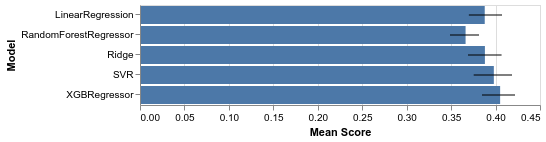

In [14]:
bars = alt.Chart(results).mark_bar().encode(
    x=alt.X('mean(Score):Q', title='Mean Score'),
    y=alt.Y('Model:N', sort=alt.EncodingSortField(op='mean', field='Score', order='descending'))
)

error_bars = bars.mark_errorbar(extent='ci').encode(
    x=alt.X('Score:Q', title='Mean Score')
)

bars + error_bars

We can see that with default parameters, gradient boosting tree models have better performance than other models. However, the performance of support vector machine model (SVR) is quite close. Therefore I'll fine tune the SVR and XGBRegressor models. **Note:** In this toy example, the performance of linear regression is quit close to nonlinear methods. In my other projects I have noticed that XGBoost models tend to outperform linear models by a large margine. 

## 3.1. Fine tune the support vector machine model

In [24]:
from sklearn.model_selection import GridSearchCV

svr = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', SVR())
    ])

param_grid = { 
    'regressor__C': [0.1, 0.25, 0.5, 0.75, 1],
    'regressor__epsilon': [0.05, 0.1, 0.2, 0.25, 0.3],
}

svr_search = GridSearchCV(svr, param_grid, n_jobs= -1, cv=3, verbose=1, return_train_score=True)
                  
svr_search.fit(X_train, y_train)  

print(svr_search.best_params_)    
print(svr_search.best_score_)
print(svr_search.score(X_test, y_test))

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  6.5min finished
/home/dinghai/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/dinghai/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


{'regressor__C': 0.5, 'regressor__epsilon': 0.3}
0.39040655367496724
0.35061984731477114


Save model:

In [25]:
import pickle

pickle.dump(svr_search.best_estimator_, (result_dir/'svr_model.pkl').open('wb'))

svr_model = pickle.load((result_dir/'svr_model.pkl').open('rb')) 

## 3.2. Fine tune the gradient boosting tree (xgboost) model

In [26]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

xgb_model = XGBRegressor(objective='reg:squarederror')

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.01, 0.2), # default 0.1 
    "max_depth": randint(2, 8), # default 3
    "n_estimators": randint(100, 500), # default 100
    "subsample": uniform(0.6, 0.4)
}

xgb_search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=1, 
                                n_iter=400, cv=3, verbose=1, n_jobs=-1, return_train_score=True)

# Fit with early stop
eval_set = [(X_test, y_test)]
xgb_search.fit(X_train, y_train, early_stopping_rounds=10, 
               eval_metric="rmse", eval_set=eval_set, verbose=False)

print(xgb_search.best_params_)    
print(xgb_search.best_score_)
print(xgb_search.score(X_test, y_test))

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   42.2s
/home/dinghai/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 19.8min finished
/home/dinghai/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


{'colsample_bytree': 0.8050019806670101, 'gamma': 0.2137644117797886, 'learning_rate': 0.013259352772522206, 'max_depth': 7, 'n_estimators': 498, 'subsample': 0.8045848865612224}
0.4141026899316184
0.4502044320865634


Save model:

In [27]:
pickle.dump(xgb_search.best_estimator_, (result_dir/'xgb_model.pkl').open('wb'))

xgb_model = pickle.load((result_dir/'xgb_model.pkl').open('rb')) 

## 3.3. Plot prediction vs observation for the training data

In [28]:
Yy = pd.DataFrame({'Observed':y_train, 
                   'Predicted by SVM':svr_model.predict(X_train),
                   'Predicted by XGboost':xgb_model.predict(X_train),
                   })

Yy = Yy.reset_index()

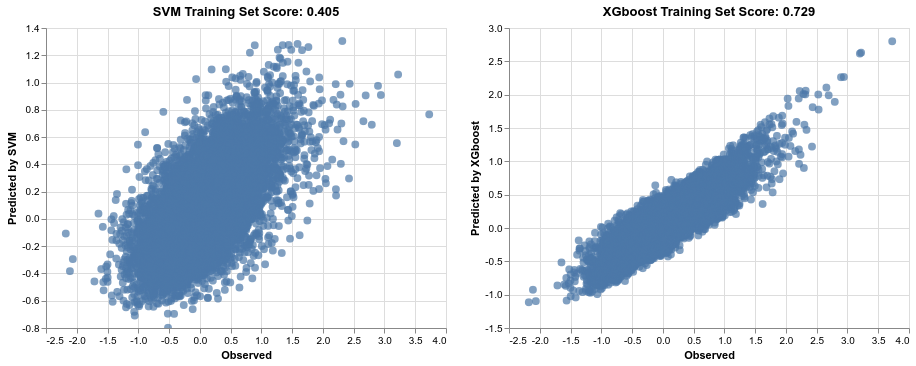

In [29]:
alt.data_transformers.disable_max_rows()

p1 = alt.Chart(Yy).mark_circle(size=60).encode(
    y='Predicted by SVM',
    x='Observed',
    tooltip = ['gene_symbol', 'pAid']
).properties(
    title=f'SVM Training Set Score: {svr_model.score(X_train, y_train):.3f}'
).interactive()

p2 = alt.Chart(Yy).mark_circle(size=60).encode(
    y='Predicted by XGboost',
    x='Observed',
    tooltip = ['gene_symbol', 'pAid']
).properties(
    title=f'XGboost Training Set Score: {xgb_model.score(X_train, y_train):.3f}'
).interactive()

(p1 | p2)

## 3.4. Plot prediction vs observation for the testing data

In [30]:
Yy = pd.DataFrame({'Observed':y_test, 
                   'Predicted by SVM':svr_model.predict(X_test),
                   'Predicted by XGboost':xgb_model.predict(X_test),
                   })

Yy = Yy.reset_index()

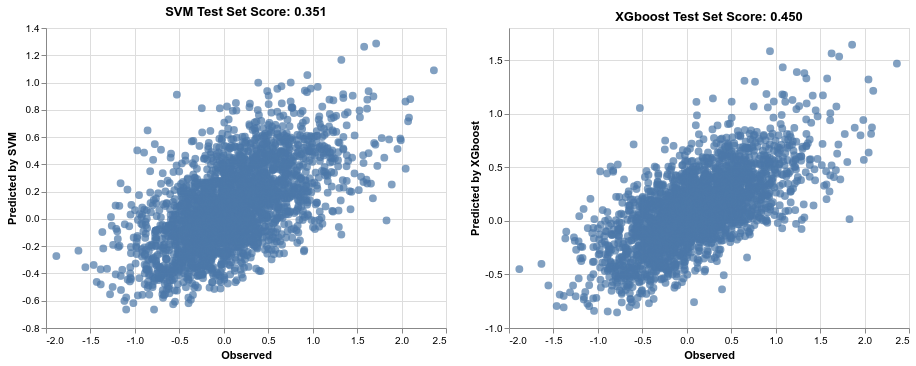

In [31]:
p1 = alt.Chart(Yy).mark_circle(size=60).encode(
    y='Predicted by SVM',
    x='Observed',
    tooltip = ['gene_symbol', 'pAid']
).properties(
    title=f'SVM Test Set Score: {svr_model.score(X_test, y_test):.3f}'
).interactive()

p2 = alt.Chart(Yy).mark_circle(size=60).encode(
    y='Predicted by XGboost',
    x='Observed',
    tooltip = ['gene_symbol', 'pAid']
).properties(
    title=f'XGboost Test Set Score: {xgb_model.score(X_test, y_test):.3f}'
).interactive()

(p1 | p2)

We can see that after fine tunning the XGboost model still has a higher score than the support vector machine model when tested on the test data set. Therefore I will focus on the XGboost model to interpret the importance of different features.

## 4. Model interpretation 
SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model, by connecting optimal credit allocation with local explanations using the classic Shapley values from game theory.

In [33]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)

## 4.1. Plot feature importance:

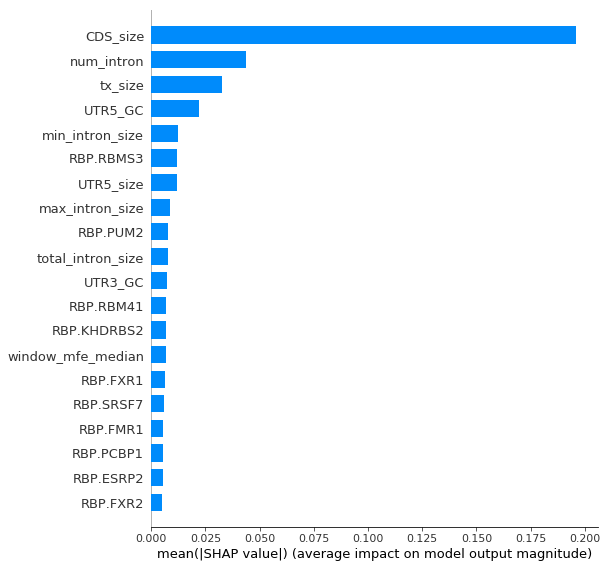

In [34]:
shap.summary_plot(shap_values, X, plot_type="bar")

## 4.2. Summarize the effects of all the features

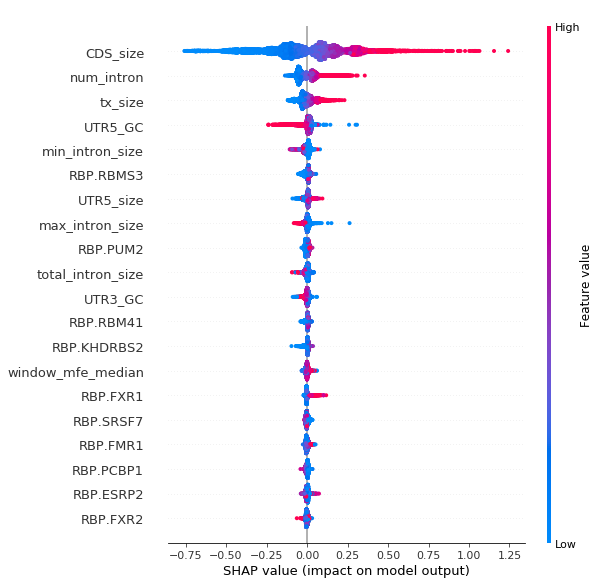

In [35]:
shap.summary_plot(shap_values, X)

## 4.3. Create a dependence plot to show the effect of a single feature across the whole dataset

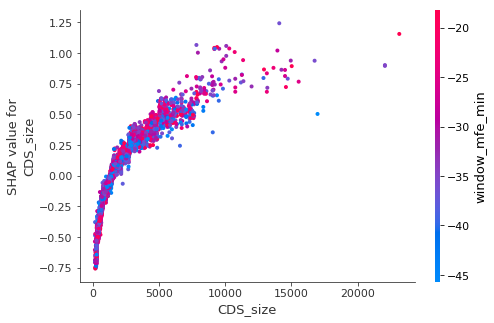

In [36]:
# 'num_intron' is automatically chosen as an interaction feature
shap.dependence_plot("CDS_size", shap_values, X)

Clearly we can see that as the CDS size increases, the prediction increases. Large CDS size is also correlated with high intron numbers.

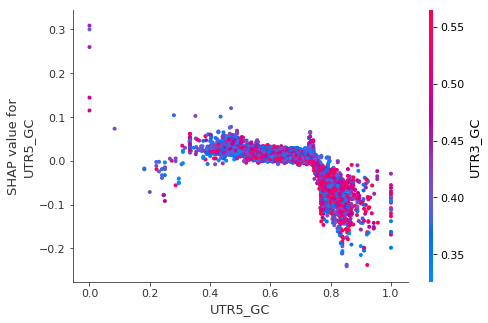

In [37]:
# We can specify an interaction feature
shap.dependence_plot("UTR5_GC", shap_values, X, interaction_index='UTR3_GC')

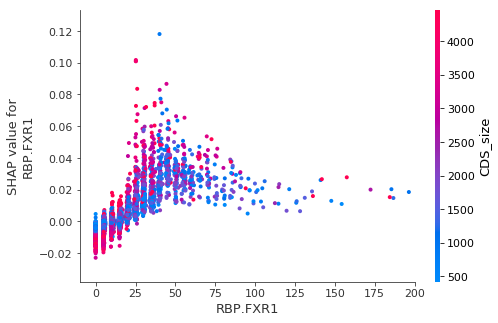

In [42]:
# 'CDS_size' is automatically chosen as an interaction feature
shap.dependence_plot("RBP.FXR1", shap_values, X, xmax=200)

## 4.4. Another way to plot feature interaction

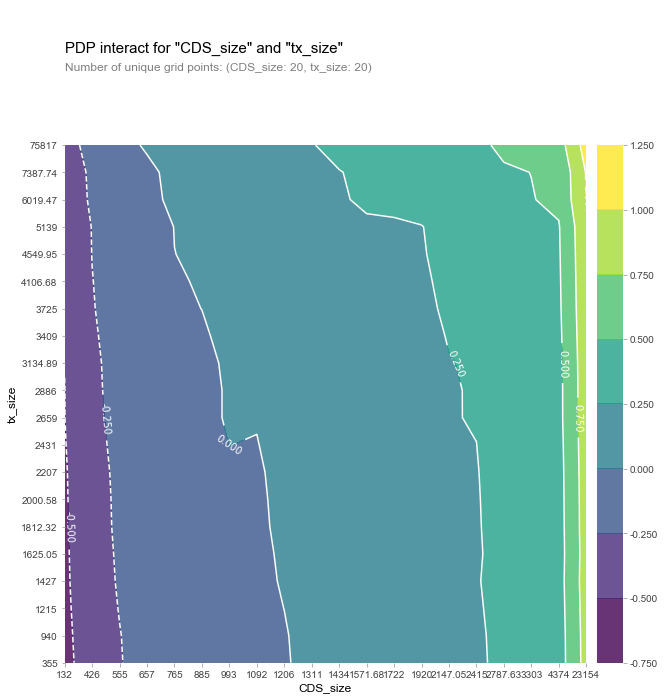

In [39]:
from pdpbox import pdp

feats = ['CDS_size', 'tx_size']

p = pdp.pdp_interact(xgb_model, X, X.columns, feats, num_grid_points=[20, 20])

pdp.pdp_interact_plot(p, feats, x_quantile=True, figsize=(10, 12));

Compared with CDS size, transcript size does not matter much.

## 4.5. Plot how individual feature impacts prediction for individual genes:
If the gene has APA isoforms, they will all be plotted.

In [55]:
def explain_gene(m=xgb_model, X=X, symbol='Timp2'):
    import shap
    shap.initjs()
    
    explainer = shap.TreeExplainer(m)
    shap_values = explainer.shap_values(X)
    
    idx = (X.reset_index()['gene_symbol'] == symbol)
    idx = np.where(idx)
    
    for i in idx[0]:
        out_names = symbol+','+X.reset_index().loc[i,'pAid'] if 'pAid' in X.index.values \
        else symbol
        p = shap.force_plot(explainer.expected_value, shap_values[i,:], X.iloc[i,:], 
                            out_names=out_names)
        display(p)

In [56]:
explain_gene(symbol='Col12a1')

We can see that Col12a1 has one 3'UTR APA isoform. It is predicted to have a high log2(Nuclear/Cytoplasm) score (2.07), which is much higher than the base value (0.1126), because it has a large CDS size and high number of introns.

In [60]:
explain_gene(symbol='Timp2')

We can see that Timp2 has three 3'UTR APA isoforms, all of which are predicted to have low log2(Nuclear/Cytoplasm) scores (< 0.10), which are lower than the base value (0.1069), because they have small CDS size and low number of introns.

Because github won't display the above javascript plots, I'm posting a screenshot here:
![explain_genes](../images/explain_genes.png)

## Biological insights
It seems that transcripts with large CDS size and/or high number of introns tend to be more enriched in the nucleus than in the cytoplasm. Transcripts with low 5'UTR GC% also tend to be slightly more enriched in the nucleus. 

However, we have to remember that our best model (XGboost) can only explain about 45% of the variance observed in the test data set. Moreover, although tree-based models are not sensitive to correlated features during inference, they can still incorrectly calculate the importance of correlated features. In this analysis, CDS size is correlated with transcript size while CDS GC% is correlated with 3'UTR GC%. Therefore their importance may be miss calculated.